In [1]:
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from semantics.pipeline import Pipeline
from semantics.train import Trainer, TrainerConfig
import semantics.vision as sv

# Configuration
batch_size = 128
img_size = 32
patch_size = 2
num_channels = 3
modulation = True
channel_mean = 0.0
channel_std = 0.1
channel_snr = 10.0
channel_avg_power = None

embed_dims = [32, 64, 128, 256]
depths = [2, 2, 2, 2]
num_heads = [4, 8, 8, 8]
latent_C = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Encoder / Decoder / Channel configs
encoder_cfg = {
    "img_size": img_size,
    "patch_size": patch_size,
    "embed_dims": embed_dims,
    "depths": depths,
    "num_heads": num_heads,
    "C_out": latent_C,
    "window_size": 4,
    "use_modulation": modulation,
    "in_chans": num_channels,
}

decoder_cfg = {
    "img_size": img_size,
    "patch_size": patch_size,
    "embed_dims": list(reversed(embed_dims)),
    "depths": list(reversed(depths)),
    "num_heads": list(reversed(num_heads)),
    "C_in": latent_C,
    "window_size": 4,
    "use_modulation": modulation,
    "out_chans": num_channels,
}

channel_cfg = {
    "mean": channel_mean,
    "std": channel_std,
    "snr": channel_snr,
    "avg_power": channel_avg_power,
}

# Encoder / Decoder / Channel
encoder = sv.WITTEncoder(**encoder_cfg).to(device)
decoder = sv.WITTDecoder(**decoder_cfg).to(device)
channel = sv.AWGNChannel(**channel_cfg).to(device)

pipeline = Pipeline(encoder, channel, decoder).to(device)

# Data
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

train_ds = datasets.CIFAR10("./data", train=True, download=True, transform=transform)
val_ds = datasets.CIFAR10("./data", train=False, download=True, transform=transform)

pin = torch.cuda.is_available()
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=pin)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=pin)

# Optimizer / Loss / Metrics
optimizer = AdamW(pipeline.parameters(), lr=3e-4)
criterion = torch.nn.L1Loss()
metrics = {
    "psnr": sv.PSNRMetric(),
    "ssim": sv.SSIMMetric(data_range=1.0, size_average=True, channel=3),
}

# Trainer
cfg = TrainerConfig(
    num_epochs=50,
    use_amp=True,
    amp_dtype="auto",
    grad_accum_steps=1,
    clip_grad_norm=1.0,
    compile_model=False,
)

trainer = Trainer(
    pipeline=pipeline,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=criterion,
    config=cfg,
    metrics=metrics,
)

trainer.train()


/home/jmadden2/anaconda3/envs/semantics/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jmadden2/anaconda3/envs/semantics/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


[epoch 000] epoch=0.0000 train_loss=0.1616 val_loss=0.1321 val_psnr=15.1374 val_ssim=0.1776


[epoch 001] epoch=1.0000 train_loss=0.1137 val_loss=0.1024 val_psnr=17.1305 val_ssim=0.3105


[epoch 002] epoch=2.0000 train_loss=0.0941 val_loss=0.0883 val_psnr=18.3315 val_ssim=0.4114


[epoch 003] epoch=3.0000 train_loss=0.0849 val_loss=0.0859 val_psnr=18.5472 val_ssim=0.4662


[epoch 004] epoch=4.0000 train_loss=0.0803 val_loss=0.0785 val_psnr=19.2394 val_ssim=0.4987


[epoch 005] epoch=5.0000 train_loss=0.0775 val_loss=0.0777 val_psnr=19.3985 val_ssim=0.5199


[epoch 006] epoch=6.0000 train_loss=0.0754 val_loss=0.0756 val_psnr=19.5569 val_ssim=0.5425


[epoch 007] epoch=7.0000 train_loss=0.0739 val_loss=0.0726 val_psnr=19.8679 val_ssim=0.5472


[epoch 008] epoch=8.0000 train_loss=0.0725 val_loss=0.0721 val_psnr=19.9690 val_ssim=0.5595


[epoch 009] epoch=9.0000 train_loss=0.0713 val_loss=0.0715 val_psnr=19.9926 val_ssim=0.5804


[epoch 010] epoch=10.0000 train_loss=0.0704 val_loss=0.0699 val_psnr=20.2192 val_ssim=0.5772


[epoch 011] epoch=11.0000 train_loss=0.0695 val_loss=0.0693 val_psnr=20.2837 val_ssim=0.5882


[epoch 012] epoch=12.0000 train_loss=0.0688 val_loss=0.0690 val_psnr=20.3182 val_ssim=0.5934


[epoch 013] epoch=13.0000 train_loss=0.0682 val_loss=0.0676 val_psnr=20.4764 val_ssim=0.5944


[epoch 014] epoch=14.0000 train_loss=0.0675 val_loss=0.0674 val_psnr=20.5015 val_ssim=0.6037


[epoch 015] epoch=15.0000 train_loss=0.0669 val_loss=0.0670 val_psnr=20.5616 val_ssim=0.6114


[epoch 016] epoch=16.0000 train_loss=0.0665 val_loss=0.0660 val_psnr=20.6552 val_ssim=0.6115


[epoch 017] epoch=17.0000 train_loss=0.0660 val_loss=0.0659 val_psnr=20.6949 val_ssim=0.6172


[epoch 018] epoch=18.0000 train_loss=0.0655 val_loss=0.0654 val_psnr=20.7627 val_ssim=0.6213


[epoch 019] epoch=19.0000 train_loss=0.0651 val_loss=0.0658 val_psnr=20.7666 val_ssim=0.6251


[epoch 020] epoch=20.0000 train_loss=0.0647 val_loss=0.0646 val_psnr=20.8738 val_ssim=0.6296


[epoch 021] epoch=21.0000 train_loss=0.0644 val_loss=0.0647 val_psnr=20.8278 val_ssim=0.6330


[epoch 022] epoch=22.0000 train_loss=0.0641 val_loss=0.0640 val_psnr=20.9518 val_ssim=0.6322


[epoch 023] epoch=23.0000 train_loss=0.0639 val_loss=0.0645 val_psnr=20.8602 val_ssim=0.6409


[epoch 024] epoch=24.0000 train_loss=0.0636 val_loss=0.0638 val_psnr=20.9701 val_ssim=0.6416


[epoch 025] epoch=25.0000 train_loss=0.0634 val_loss=0.0634 val_psnr=21.0052 val_ssim=0.6402


[epoch 026] epoch=26.0000 train_loss=0.0632 val_loss=0.0633 val_psnr=21.0082 val_ssim=0.6434


[epoch 027] epoch=27.0000 train_loss=0.0629 val_loss=0.0636 val_psnr=21.0549 val_ssim=0.6440


[epoch 028] epoch=28.0000 train_loss=0.0628 val_loss=0.0628 val_psnr=21.0917 val_ssim=0.6469


[epoch 029] epoch=29.0000 train_loss=0.0625 val_loss=0.0626 val_psnr=21.1061 val_ssim=0.6480


[epoch 030] epoch=30.0000 train_loss=0.0625 val_loss=0.0623 val_psnr=21.1649 val_ssim=0.6461


[epoch 031] epoch=31.0000 train_loss=0.0622 val_loss=0.0625 val_psnr=21.1662 val_ssim=0.6458


[epoch 032] epoch=32.0000 train_loss=0.0620 val_loss=0.0621 val_psnr=21.1628 val_ssim=0.6508


[epoch 033] epoch=33.0000 train_loss=0.0619 val_loss=0.0620 val_psnr=21.1640 val_ssim=0.6525


[epoch 034] epoch=34.0000 train_loss=0.0619 val_loss=0.0624 val_psnr=21.1669 val_ssim=0.6524


[epoch 035] epoch=35.0000 train_loss=0.0616 val_loss=0.0620 val_psnr=21.1969 val_ssim=0.6547


[epoch 036] epoch=36.0000 train_loss=0.0616 val_loss=0.0616 val_psnr=21.2348 val_ssim=0.6536


[epoch 037] epoch=37.0000 train_loss=0.0613 val_loss=0.0621 val_psnr=21.1469 val_ssim=0.6535


[epoch 038] epoch=38.0000 train_loss=0.0613 val_loss=0.0621 val_psnr=21.1803 val_ssim=0.6571


[epoch 039] epoch=39.0000 train_loss=0.0612 val_loss=0.0613 val_psnr=21.2567 val_ssim=0.6564


[epoch 040] epoch=40.0000 train_loss=0.0612 val_loss=0.0617 val_psnr=21.2198 val_ssim=0.6487


[epoch 041] epoch=41.0000 train_loss=0.0609 val_loss=0.0615 val_psnr=21.2376 val_ssim=0.6561


[epoch 042] epoch=42.0000 train_loss=0.0609 val_loss=0.0616 val_psnr=21.2799 val_ssim=0.6541


[epoch 043] epoch=43.0000 train_loss=0.0607 val_loss=0.0611 val_psnr=21.3009 val_ssim=0.6606


[epoch 044] epoch=44.0000 train_loss=0.0607 val_loss=0.0610 val_psnr=21.3213 val_ssim=0.6568


[epoch 045] epoch=45.0000 train_loss=0.0606 val_loss=0.0610 val_psnr=21.3180 val_ssim=0.6576


[epoch 046] epoch=46.0000 train_loss=0.0605 val_loss=0.0610 val_psnr=21.3389 val_ssim=0.6612


[epoch 047] epoch=47.0000 train_loss=0.0604 val_loss=0.0608 val_psnr=21.3674 val_ssim=0.6635


[epoch 048] epoch=48.0000 train_loss=0.0603 val_loss=0.0604 val_psnr=21.3814 val_ssim=0.6618


[epoch 049] epoch=49.0000 train_loss=0.0603 val_loss=0.0611 val_psnr=21.2943 val_ssim=0.6653


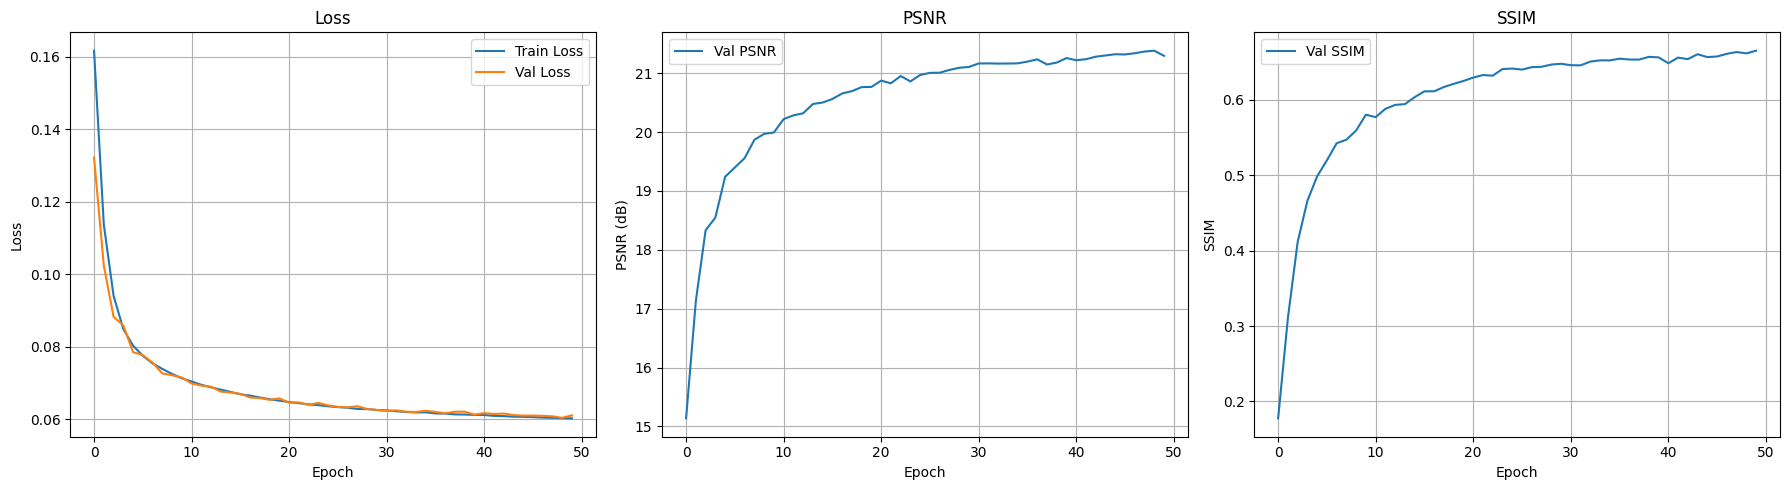

In [2]:
import matplotlib.pyplot as plt

history = trainer.history

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Train & Val Loss
axes[0].plot(history["train_loss"], label="Train Loss")
axes[0].plot(history["val_loss"], label="Val Loss")
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid()

# PSNR
axes[1].plot(history["val_psnr"], label="Val PSNR")
axes[1].set_title("PSNR")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("PSNR (dB)")
axes[1].legend()
axes[1].grid()

# SSIM
axes[2].plot(history["val_ssim"], label="Val SSIM")
axes[2].set_title("SSIM")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("SSIM")
axes[2].legend()
axes[2].grid()

plt.tight_layout()
plt.show()

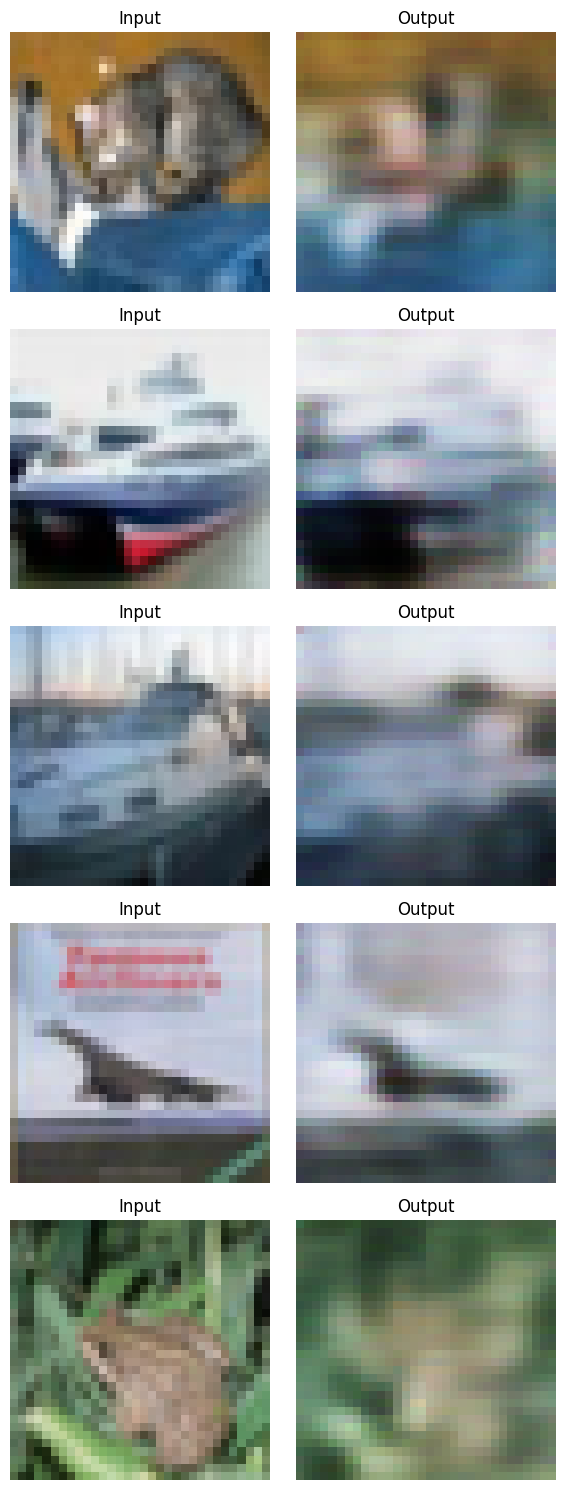

In [3]:
import numpy as np

# Get a batch of images from the validation loader
images, _ = next(iter(val_loader))
images = images.to(device)

# Pass images through the pipeline
ckpt_path = "checkpoints/best.pt"
trainer.load(ckpt_path)
pipeline = trainer.pipeline
with torch.no_grad():
    outputs, _ = pipeline(images)

# Move tensors to CPU and convert to numpy
inputs_np = images.cpu().numpy()
outputs_np = outputs.cpu().numpy()

# Visualize first 5 images: input and output side by side
fig, axes = plt.subplots(5, 2, figsize=(6, 15))
for i in range(5):
    # Input image
    axes[i, 0].imshow(np.transpose(inputs_np[i], (1, 2, 0)))
    axes[i, 0].set_title("Input")
    axes[i, 0].axis("off")
    # Output image
    axes[i, 1].imshow(np.transpose(outputs_np[i], (1, 2, 0)))
    axes[i, 1].set_title("Output")
    axes[i, 1].axis("off")
plt.tight_layout()
plt.show()